## Importing the packages

In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style='ticks', font_scale=1.25)

warnings.filterwarnings('ignore')

In [2]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
#from sklearn.feature_selection import RFE
#from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, \
    classification_report, accuracy_score, precision_score, recall_score

## Importing Data

In [3]:
bankcalls = pd.read_excel('./BankCalls.xlsx')

## UDFs

In [4]:
def conti_var_summary(x):

    # freq and missings
    n_total = x.shape[0]
    n_miss = x.isna().sum()
    perc_miss = n_miss * 100 / n_total

    # outliers - iqr
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    lc_iqr = q1 - 1.5 * iqr
    uc_iqr = q3 + 1.5 * iqr

    return pd.Series([
        x.dtype,
        x.nunique(), n_total,
        x.count(), n_miss, perc_miss,
        x.sum(),
        x.mean(),
        x.std(),
        x.var(), lc_iqr, uc_iqr,
        x.min(),
        x.quantile(0.01),
        x.quantile(0.05),
        x.quantile(0.10),
        x.quantile(0.25),
        x.quantile(0.5),
        x.quantile(0.75),
        x.quantile(0.90),
        x.quantile(0.95),
        x.quantile(0.99),
        x.max()
    ],
                     index=[
                         'dtype', 'cardinality', 'n_tot', 'n', 'nmiss',
                         'perc_miss', 'sum', 'mean', 'std', 'var', 'lc_iqr',
                         'uc_iqr', 'min', 'p1', 'p5', 'p10', 'p25', 'p50',
                         'p75', 'p90', 'p95', 'p99', 'max'
                     ])

In [5]:
def cat_var_summary(x):
    Mode = x.value_counts().sort_values(ascending=False)[0:1].reset_index()
    return pd.Series([
        x.count(),
        x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1],
        round(Mode.iloc[0, 1] * 100 / x.count(), 2)
    ],
                     index=['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [6]:
bankcalls.isnull().sum()

age                   0
job                   0
marital               0
housing               0
loan                  0
month                 0
duration              0
campaign attending    0
Customer since        0
previous Savings      0
emp_var_rate          0
cons_price_idx        0
nr_employed           0
Output                0
dtype: int64

## Data Inspection

In [7]:
bankcalls.columns

Index(['age', 'job', 'marital', 'housing', 'loan', 'month', 'duration',
       'campaign attending', 'Customer since ', 'previous Savings',
       'emp_var_rate', 'cons_price_idx', 'nr_employed', 'Output'],
      dtype='object')

### Fixing the Column Names

In [8]:
bankcalls.rename(columns=lambda x: x.lower().strip().replace(" ", "_"),
                 inplace=True)

In [9]:
bankcalls.columns

Index(['age', 'job', 'marital', 'housing', 'loan', 'month', 'duration',
       'campaign_attending', 'customer_since', 'previous_savings',
       'emp_var_rate', 'cons_price_idx', 'nr_employed', 'output'],
      dtype='object')

### Checking the metadata

In [10]:
bankcalls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 41188 non-null  int64  
 1   job                 41188 non-null  object 
 2   marital             41188 non-null  object 
 3   housing             41188 non-null  object 
 4   loan                41188 non-null  object 
 5   month               41188 non-null  object 
 6   duration            41188 non-null  int64  
 7   campaign_attending  41188 non-null  int64  
 8   customer_since      41188 non-null  int64  
 9   previous_savings    41188 non-null  int64  
 10  emp_var_rate        41188 non-null  float64
 11  cons_price_idx      41188 non-null  float64
 12  nr_employed         41188 non-null  float64
 13  output              41188 non-null  int64  
dtypes: float64(3), int64(6), object(5)
memory usage: 4.4+ MB


### Attribute Information:
Source : [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/bank+marketing)

#### Input variables:
* *Bank client data:*
    1. **age** (numeric)
    2. **job** : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
    3. **marital** : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
    4. **housing** : has housing loan? (categorical: 'no','yes','unknown')
    5. **loan** : has personal loan? (categorical: 'no','yes','unknown')


* *Related with the last contact of the current campaign:*
    6. **month** : last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
    7. **duration** : last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.


* *Other attributes:*
    8. **campaign_attending** : number of contacts performed during this campaign and for this client (numeric, includes last contact)
    9. **customer_since** : number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
    10. **previous_savings** : number of contacts performed before this campaign and for this client (numeric)


* *Social and Economic context attributes:*
    11. **emp_var_rate** : employment variation rate. quarterly indicator (numeric)
    12. **cons_price_idx** : consumer price index. monthly indicator (numeric)
    13. **nr_employed** : number of employees. quarterly indicator (numeric)

#### Output variable (desired target):
* 
    14. **output** : has the client subscribed a term deposit? (binary: 'yes'[1], 'no'[0])



In [11]:
bankcalls.head()

,age,job,marital,housing,loan,month,duration,campaign_attending,customer_since,previous_savings,emp_var_rate,cons_price_idx,nr_employed,output
0,44,blue-collar,married,yes,no,aug,210,1,999,0,1.4,93.444,5228.1,0
1,53,technician,married,no,no,nov,138,1,999,0,-0.1,93.200,5195.8,0
2,28,management,single,yes,no,jun,339,3,6,2,-1.7,94.055,4991.6,1
3,39,services,married,no,no,apr,185,2,999,0,-1.8,93.075,5099.1,0
4,55,retired,married,yes,no,aug,137,1,3,1,-2.9,92.201,5076.2,1


### Distribution of the Output variable

In [12]:
bankcalls.output.value_counts() / bankcalls.output.notna().sum()

0    0.887346
1    0.112654
Name: output, dtype: float64

In [13]:
bankcalls.shape

(41188, 14)

In [14]:
# EDA for all the variables
bankcalls.select_dtypes(['int64', 'float64']).apply(conti_var_summary)

,age,duration,campaign_attending,customer_since,previous_savings,emp_var_rate,cons_price_idx,nr_employed,output
dtype,int64,int64,int64,int64,int64,float64,float64,float64,int64
cardinality,78,1544,42,27,8,10,26,11,2
n_tot,41188,41188,41188,41188,41188,41188,41188,41188,41188
n,41188,41188,41188,41188,41188,41188,41188,41188,41188
nmiss,0,0,0,0,0,0,0,0,0
perc_miss,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sum,1648511,10638243,105754,39642439,7124,3372.7,3854194.464,212819875.1,4640
mean,40.02406,258.28501,2.567593,962.475454,0.172963,0.081886,93.575664,5167.035911,0.112654
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.57096,0.57884,72.251528,0.316173
var,108.602451,67225.728877,7.672975,34935.687284,0.244927,2.467915,0.335056,5220.28325,0.099966


In [15]:
bankcalls.select_dtypes(['object']).apply(cat_var_summary)

,job,marital,housing,loan,month
N,41188,41188,41188,41188,41188
NMISS,0,0,0,0,0
MODE,admin.,married,yes,no,may
FREQ,10422,24928,21576,33950,13769
PERCENT,25.3,60.52,52.38,82.43,33.43


## Plots

AGE
skewness = 0.7846968157646645


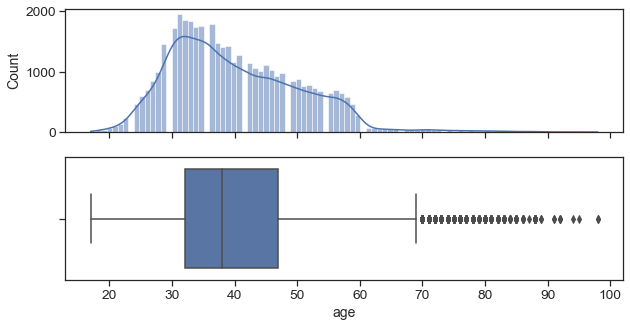

JOB


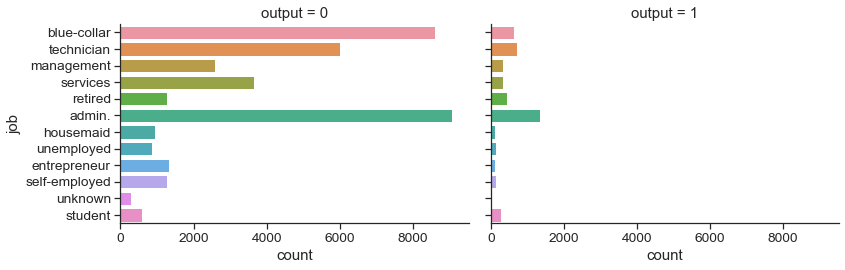

MARITAL


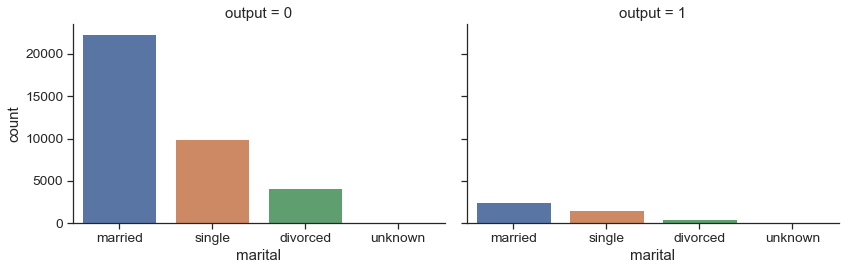

HOUSING


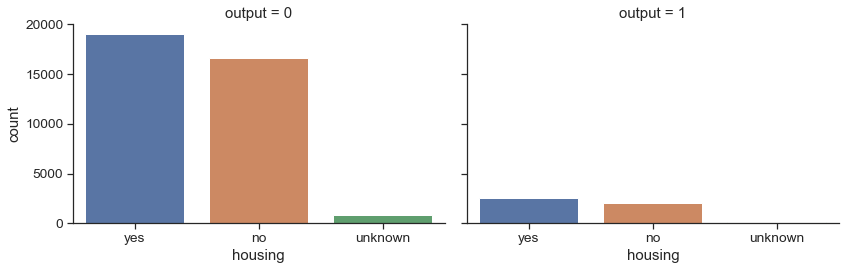

LOAN


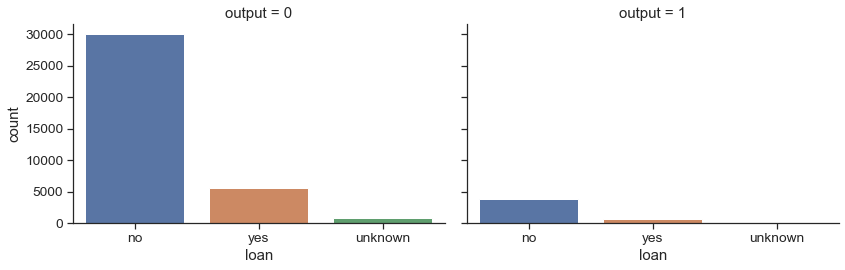

MONTH


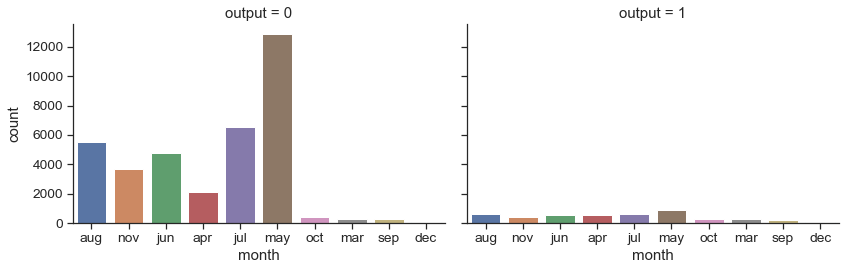

DURATION
skewness = 3.2631412552628314


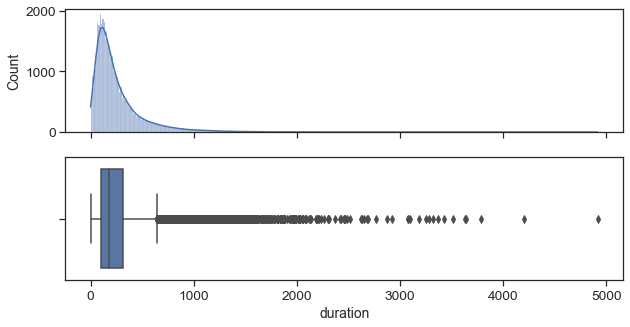

CAMPAIGN_ATTENDING
skewness = 4.762506697067007


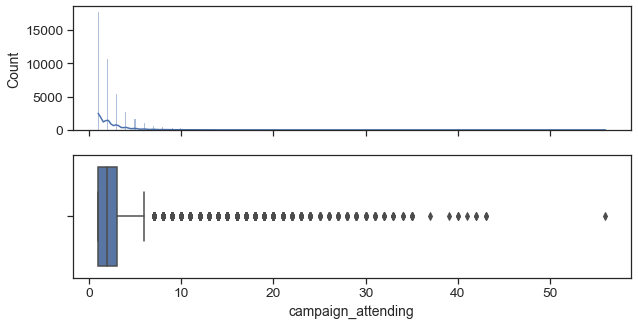

CUSTOMER_SINCE
skewness = -4.922189916418164


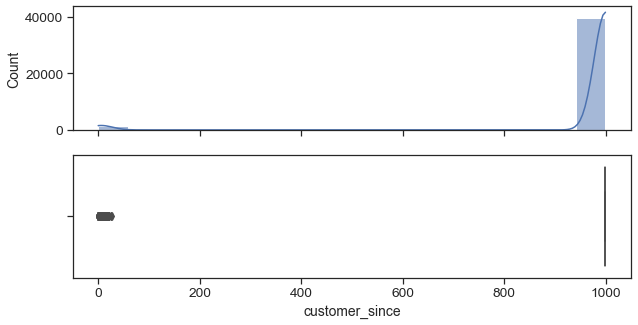

PREVIOUS_SAVINGS
skewness = 3.8320422428611836


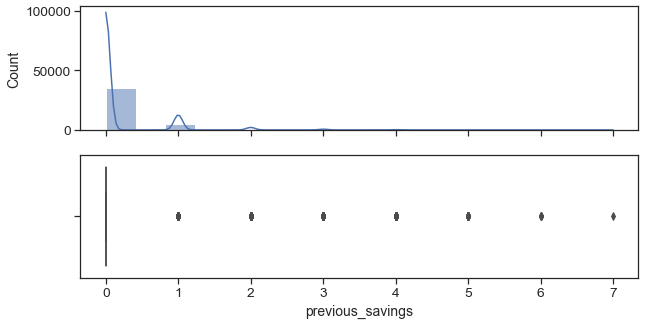

EMP_VAR_RATE
skewness = -0.7240955492472559


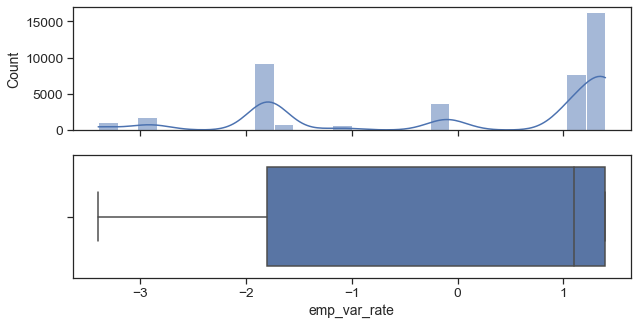

CONS_PRICE_IDX
skewness = -0.2308876513578066


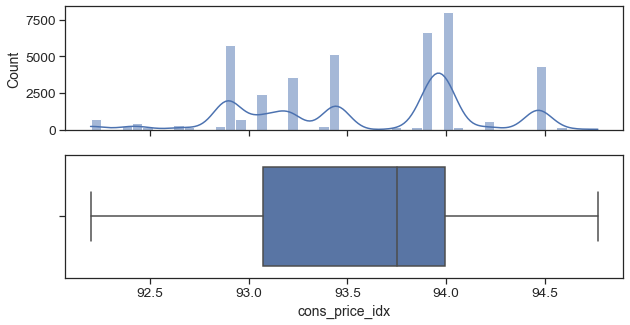

NR_EMPLOYED
skewness = -1.044262407089151


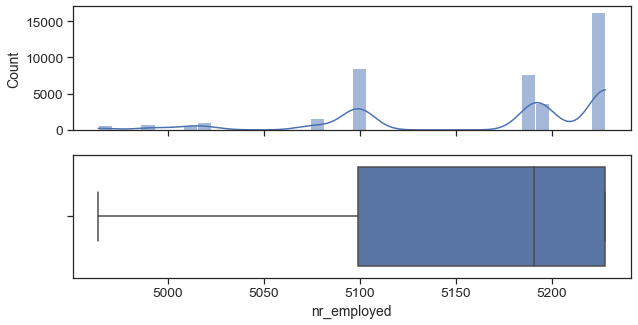

OUTPUT
skewness = 2.4503301382077263


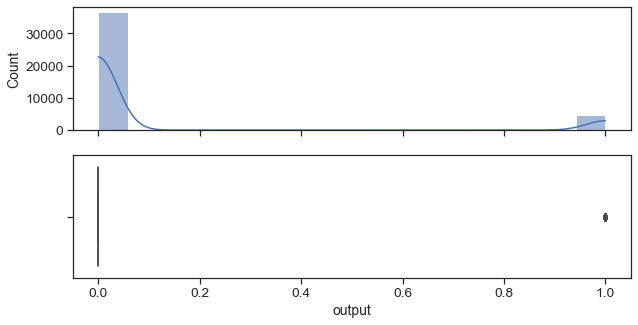

In [16]:
# Using Pairplot to check histograms and relation between two variables
for i in bankcalls.columns:
    try:
        print(i.upper(), '\nskewness = ', bankcalls.loc[:, i].skew(), sep='')
        params = {'figure.figsize': (10, 5), 'axes.labelsize': 14}
        plt.rcParams.update(params)
        fig, axs = plt.subplots(2, 1, sharex=True)
        sns.histplot(data=bankcalls, x=i, kde=True, ax=axs[0])
        sns.boxplot(x=bankcalls.loc[:, i], ax=axs[1])
        plt.show()
    except:
        print(i.upper())
        params = {'figure.figsize': (10, 5), 'axes.labelsize': 14}
        plt.rcParams.update(params)
        sns.set(style='ticks', font_scale=1.25)
        if i != 'job':
            sns.catplot(x=i,
                        col='output',
                        data=bankcalls,
                        kind='count',
                        height=4,
                        aspect=1.5)
        else:
            sns.catplot(y=i,
                        col='output',
                        data=bankcalls,
                        kind='count',
                        height=4,
                        aspect=1.5)
        plt.show()

In [17]:
# bankcalls.housing = bankcalls.housing.apply(lambda x: 1 if 'yes' in x else 0)
# bankcalls.loan = bankcalls.loan.apply(lambda x: 1 if 'yes' in x else 0)

## Bi-variate analysis to identify corr

In [18]:
# correlation matrix
corr_matrix = bankcalls.corr()

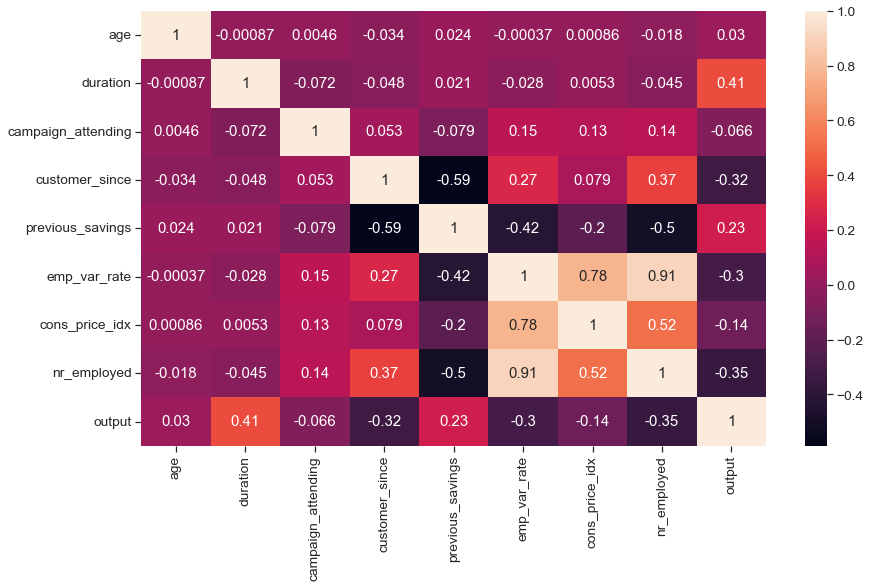

In [19]:
# visualizing correlation matrix in Seaborn using a heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(bankcalls.corr(), annot=True)
plt.show()

## Building Logistic Regression Model

In [20]:
# Train and Test split
train, test = train_test_split(bankcalls,
                               test_size=0.3,
                               random_state=2,
                               stratify=bankcalls.output)

In [21]:
# print the columns
train.columns

Index(['age', 'job', 'marital', 'housing', 'loan', 'month', 'duration',
       'campaign_attending', 'customer_since', 'previous_savings',
       'emp_var_rate', 'cons_price_idx', 'nr_employed', 'output'],
      dtype='object')

In [22]:
model_eq = 'output ~ ' + ' + '.join(train.columns.difference(['output']))
model_eq

'output ~ age + campaign_attending + cons_price_idx + customer_since + duration + emp_var_rate + housing + job + loan + marital + month + nr_employed + previous_savings'

In [23]:
# execute a model for the X variables
m1 = smf.logit(formula=model_eq, data=train).fit()

Optimization terminated successfully.
         Current function value: 0.211996
         Iterations 9


In [24]:
# print the model summary stats
print(m1.summary2())

                                     Results: Logit
Model:                      Logit                    Pseudo R-squared:         0.398     
Dependent Variable:         output                   AIC:                      12294.1058
Date:                       2022-08-30 15:30         BIC:                      12583.5281
No. Observations:           28831                    Log-Likelihood:           -6112.1   
Df Model:                   34                       LL-Null:                  -10149.   
Df Residuals:               28796                    LLR p-value:              0.0000    
Converged:                  1.0000                   Scale:                    1.0000    
No. Iterations:             9.0000                                                       
-----------------------------------------------------------------------------------------
                       Coef.      Std.Err.      z     P>|z|      [0.025         0.975]   
------------------------------------------------

* **Exploratory Data Analysis**
  - Checking Optimum no of features using RFE
  - Variable Reduction using Somer's D values
  - Bi-variate analysis technique to check the predictive power of each independent against dependent
  - cutoff is 0.2 or 20% below which the variable is insignificant

### Checking Optimum no of features using RFE

In [25]:
#

In [26]:
# X_vars = bankcalls.columns.difference(['output'])
# y_var = 'output'
# X, y = bankcalls[X_vars], bankcalls[y_var]
# X = pd.get_dummies(X, drop_first=True)
# y_act = y
# nof_list = np.arange(1, bankcalls.shape[1] + 1)
# high_score = 0
# # Variable to store the optimum features
# nof = 0
# score_list = []
# X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                     test_size=0.25,
#                                                     random_state=0)
# for n in range(len(nof_list)):

#     model = LogisticRegression()
#     rfe = RFE(model, n_features_to_select=nof_list[n])
#     X_train_rfe = rfe.fit(X_train, y_train)
#     X_test_rfe = rfe.transform(X_test)
#     model.fit(X_train_rfe, y_train)
# #     rfe.fit(X, y)
# #     X = rfe.transform(X)
#     score = model.score(X_test_rfe,y_test)
#     score_list.append(score)
#     print(n)
#     if (score > high_score):
#         high_score = score
#         nof = nof_list[n]

# print("Optimum number of features: %d" % nof)
# print("Score with %d features: %f" % (nof, high_score))

### Getting the Somer's D values for all the X variables

In [27]:
# Empty dataframe to store the information
df = pd.DataFrame()

# Iterating on each X variable
for var_name in bankcalls.columns.difference(['output']):

    # Building the bivariate model and fit
    model = smf.logit(formula='output ~ ' + var_name, data=bankcalls).fit()

    # Predicting the y
    y_predicted = model.predict(bankcalls)

    # Getting the roc_auc_score
    roc_score = roc_auc_score(bankcalls.output, y_predicted)

    # Getting the Somar's D value
    somars_d = 2 * roc_score - 1

    # Storing the data in temp df
    temp_df = pd.DataFrame([var_name, roc_score, somars_d]).T

    # Concating the data with the output dataframe
    df = pd.concat([df, temp_df], axis=0)

# Adding the column names
df.columns = ['Feature', 'ROC_AUC_SCORE', 'SomarsD']

Optimization terminated successfully.
         Current function value: 0.351575
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348982
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.342848
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.321189
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.292635
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.310731
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.351960
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342170
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.352015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350595
  

In [28]:
df

,Feature,ROC_AUC_SCORE,SomarsD
0,age,0.489176,-0.021648
0,campaign_attending,0.555209,0.110419
0,cons_price_idx,0.610562,0.221124
0,customer_since,0.596747,0.193493
0,duration,0.818446,0.636892
0,emp_var_rate,0.716753,0.433506
0,housing,0.509314,0.018627
0,job,0.610273,0.220545
0,loan,0.503106,0.006212
0,marital,0.539419,0.078837


In [29]:
features = list(df.loc[df.SomarsD >= 0.2, 'Feature'])

In [30]:
features

['cons_price_idx',
 'duration',
 'emp_var_rate',
 'job',
 'month',
 'nr_employed',
 'previous_savings']

### VIF - Variance Inflation Factor

In [31]:
# Running the dmatrices
equation = 'output ~ ' + ' + '.join(features)

a, b = dmatrices(equation, data=bankcalls, return_type='dataframe')

# Getting the VIF
vif = pd.DataFrame()
vif["features"] = b.columns
vif["VIF Factor"] = [
    variance_inflation_factor(b.values, i) for i in range(b.shape[1])
]
pd.options.display.float_format = '{:.2f}'.format
vif

,features,VIF Factor
0,Intercept,3906555.55
1,job[T.blue-collar],1.52
2,job[T.entrepreneur],1.11
3,job[T.housemaid],1.08
4,job[T.management],1.20
5,job[T.retired],1.14
6,job[T.self-employed],1.10
7,job[T.services],1.27
8,job[T.student],1.09
9,job[T.technician],1.39


In [32]:
# Based on the VIF factor, selected features are :
features = [
    'cons_price_idx', 'nr_employed', 'duration', 'job', 'month',
    'previous_savings'
]

### Building the actual model

In [33]:
features

['cons_price_idx',
 'nr_employed',
 'duration',
 'job',
 'month',
 'previous_savings']

In [34]:
model_eq = 'output ~ ' + ' + '.join(features)
m2 = smf.logit(model_eq, data=train).fit()
print(m2.summary2())

Optimization terminated successfully.
         Current function value: 0.218769
         Iterations 8
                            Results: Logit
Model:                Logit              Pseudo R-squared:   0.379     
Dependent Variable:   output             AIC:                12664.6461
Date:                 2022-08-30 15:30   BIC:                12871.3763
No. Observations:     28831              Log-Likelihood:     -6307.3   
Df Model:             24                 LL-Null:            -10149.   
Df Residuals:         28806              LLR p-value:        0.0000    
Converged:            1.0000             Scale:              1.0000    
No. Iterations:       8.0000                                           
-----------------------------------------------------------------------
                      Coef.   Std.Err.    z     P>|z|   [0.025  0.975] 
-----------------------------------------------------------------------
Intercept            103.0268   3.9938  25.7966 0.0000 95.1990 

## Predicting the values 

In [35]:
# predict the values on training and testing
train_predict = m2.predict(train)
test_predict = m2.predict(test)

In [36]:
train_predict.head(5)

38918   0.88
35665   0.01
22556   0.01
31723   0.01
4507    0.01
dtype: float64

## Model Scoring

In [37]:
# combine the y actual and y predicted
train_data = pd.concat([train.output, train_predict], axis=1)
test_data = pd.concat([test.output, test_predict], axis=1)

train_data.columns = ['y_actual', 'y_pred_proba']
test_data.columns = ['y_actual', 'y_pred_proba']

In [38]:
# roc_auc_score
concordance_train = roc_auc_score(train_data.y_actual, train_data.y_pred_proba)
concordance_test = roc_auc_score(test_data.y_actual, test_data.y_pred_proba)

print('Train:', concordance_train, '| Test: ', concordance_test)

Train: 0.9277794961882978 | Test:  0.9304400823414103


### Finding the model accuracy at cutoff 0.5

In [39]:
train_data['y_pred'] = np.where(train_data.y_pred_proba >= 0.5, 1, 0)

#### Confusion Matrix

In [40]:
# confusion matrix (using crosstab)
pd.crosstab(train_data.y_actual, train_data.y_pred).loc[::-1, ::-1]

y_pred,1,0
y_actual,,
1,1190,2058
0,677,24906


In [41]:
# confusion matrix (using sklearn.metrics)
cm_p50 = confusion_matrix(train_data.y_actual, train_data.y_pred)[::-1, ::-1]

tp = cm_p50[0, 0]
tn = cm_p50[1, 1]
fp = cm_p50[1, 0]
fn = cm_p50[0, 1]

accuracy = (tp + tn) / cm_p50.sum()
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

print(cm_p50)
print('accuracy: ', accuracy, '| tpr: ', tpr, '| fpr: ', fpr)

[[ 1190  2058]
 [  677 24906]]
accuracy:  0.9051368318823488 | tpr:  0.36637931034482757 | fpr:  0.026462885509908923


#### Classification Report

In [42]:
print(classification_report(train_data.y_actual, train_data.y_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95     25583
           1       0.64      0.37      0.47      3248

    accuracy                           0.91     28831
   macro avg       0.78      0.67      0.71     28831
weighted avg       0.89      0.91      0.89     28831



### Getting the best Cut-offs 
Based on :
1. Accuracy, 
2. [ Sensitivity + Specificity ]

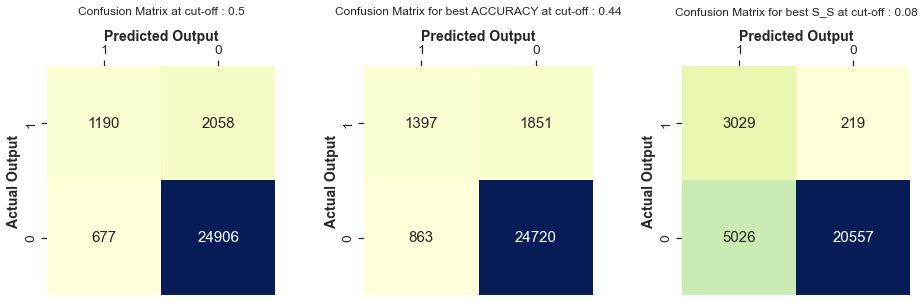

In [65]:
# Empty dataframe to store the information
cm_scores = pd.DataFrame()

# Loop for different proba values
for prob_val in np.arange(0, 1.01, 0.01):

    # Getting the y_pred
    train_data['y_pred'] = np.where(train_data.y_pred_proba >= prob_val, 1, 0)

    # Getting the confusion matrix
    cm = confusion_matrix(train_data.y_actual, train_data.y_pred)[::-1, ::-1]

    # Getting the metric values
    tp = cm[0, 0]
    tn = cm[1, 1]
    fp = cm[1, 0]
    fn = cm[0, 1]

    accuracy = (tp + tn) / cm.sum()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    s_s = tpr + 1 - fpr

    # Storing the data in temp dataframe
    temp_df = pd.DataFrame([prob_val, tp, tn, fp, fn, accuracy, tpr, fpr,
                            s_s]).T

    # Adding the data to final dataframe
    cm_scores = pd.concat([cm_scores, temp_df], axis=0)

# Adding the column names
cm_scores.columns = [
    'prob_val', 'tp', 'tn', 'fp', 'fn', 'accuracy', 'tpr', 'fpr', 's_s'
]

# Creating Heatmap
class_names = [0, 1]
fig, axs = plt.subplots(1, 3, figsize=(13.5, 4.5))
plt.subplots_adjust(wspace=0, hspace=0)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
best_cutoff = {}
j = 0
for i in ['random', 'accuracy', 's_s']:
    if i == 'random':
        best_cutoff[i] = 0.5
        cm_best_df = pd.DataFrame(cm_p50, index=[1, 0], columns=[1, 0])
    else:
        # Getting the best cutoff
        best_cutoff[i] = cm_scores.loc[cm_scores[i] == cm_scores[i].max(),
                                       'prob_val'][0]
        cm_best = cm_scores.loc[cm_scores[i] == cm_scores[i].max(),
                                ['tp', 'tn', 'fp', 'fn']]
        pd.options.display.float_format = '{:.0f}'.format
        cm_best_df = pd.DataFrame(np.array(
            [[cm_best.loc[0][0], cm_best.loc[0][3]],
             [cm_best.loc[0][2], cm_best.loc[0][1]]]),
                                  index=[1, 0],
                                  columns=[1, 0])

    # Plotting the Heat-map
    sns.heatmap(cm_best_df,
                annot=True,
                cmap="YlGnBu",
                fmt='g',
                ax=axs[j],
                cbar=False,
                square=True)
    axs[j].xaxis.tick_top()
    axs[j].xaxis.set_label_position("top")
    if i == 'random':
        axs[j].set_title(f'Confusion Matrix at cut-off : {best_cutoff[i]}',
                         y=1.2,
                         fontsize=12)
    else:
        axs[j].set_title(
            f'Confusion Matrix for best {i.upper()} at cut-off : {best_cutoff[i]}',
            y=1.2,
            fontsize=12)
    axs[j].set_ylabel('Actual Output', fontsize=14, fontweight='bold')
    axs[j].set_xlabel('Predicted Output', fontsize=14, fontweight='bold')
    j += 1
fig.tight_layout()
plt.show()

Here our target is to decrease the FN count to get all the customers who are willing to subscribe to the bank Scheme and also need to increase TN to control the campaign costs for the bank. Hence, the cut off with max `s_s` **[Sensitivity + Specificity = TPR + 1 - FPR]** is chosen.

In [44]:
#cutoff_chosen = best_cutoff['accuracy']
cutoff_chosen = best_cutoff['s_s']
cutoff_chosen

0.08

### Final predictions at best cutoff

In [45]:
train_data['y_pred'] = np.where(train_data.y_pred_proba >= cutoff_chosen, 1, 0)
test_data['y_pred'] = np.where(test_data.y_pred_proba >= cutoff_chosen, 1, 0)

### Classification report at best cutoff

In [46]:
print('TRAIN DATA')
print(classification_report(train_data.y_actual, train_data.y_pred))
print('-----------------------------------------------------')
print('TEST DATA')
print(classification_report(test_data.y_actual, test_data.y_pred))

TRAIN DATA
              precision    recall  f1-score   support

           0       0.99      0.80      0.89     25583
           1       0.38      0.93      0.54      3248

    accuracy                           0.82     28831
   macro avg       0.68      0.87      0.71     28831
weighted avg       0.92      0.82      0.85     28831

-----------------------------------------------------
TEST DATA
              precision    recall  f1-score   support

           0       0.99      0.80      0.88     10965
           1       0.37      0.93      0.53      1392

    accuracy                           0.81     12357
   macro avg       0.68      0.87      0.71     12357
weighted avg       0.92      0.81      0.84     12357



### Model Performance in Test data

In [47]:
print("Test Accuracy:", accuracy_score(test_data.y_actual, test_data.y_pred))
print("Train Accuracy:", accuracy_score(train_data.y_actual, train_data.y_pred))
print("Test Precision:", precision_score(test_data.y_actual, test_data.y_pred))
print("Test Recall:", recall_score(test_data.y_actual, test_data.y_pred))

Test Accuracy: 0.8137897547948532
Train Accuracy: 0.818077763518435
Test Precision: 0.3702540679417642
Test Recall: 0.9317528735632183


<center>
<h6> Train Accuracy ~ Test Accuracy (close). The model is stable.
</center>

### Plotting the ROC Curve 

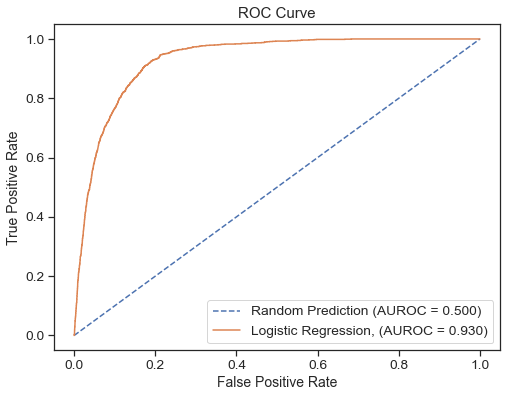

In [48]:
plt.figure(figsize=(8, 6))
r_auc = [0 for i in range(len(test_data.y_actual))]
r_fpr, r_tpr, _ = roc_curve(test_data.y_actual, r_auc)
r_auc = roc_auc_score(test_data.y_actual, r_auc)
plt.plot(r_fpr,
         r_tpr,
         linestyle="--",
         label="Random Prediction (AUROC = %0.3f)" % r_auc)

fpr, tpr, _ = roc_curve(test_data.y_actual, test_data.y_pred_proba)
auc = roc_auc_score(test_data.y_actual, test_data.y_pred_proba)
plt.plot(fpr, tpr, label="Logistic Regression, (AUROC = %0.3f)" % auc)

plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

## Decile Analysis

- Top-two deciles - Low gain customers - will not open Savings Scheme
- 3rd, 4th, 5th deciles - Medium gain customers - will open Savings Scheme with proper scrutiny
- 6th decile onwards - High gain customers - will open Savings Scheme

In [49]:
# Decile analysis for validation of models - Business validation
train_data['Deciles'] = pd.qcut(train_data.y_pred_proba, 10, labels=False)
test_data['Deciles'] = pd.qcut(test_data.y_pred_proba, 10, labels=False)

### Decile Analysis for train data

In [50]:
train_deciles = train_data.groupby('Deciles')[[
    'y_pred_proba', 'y_actual'
]].agg({
    'y_pred_proba': ['min', 'max'],
    'y_actual': ['sum', 'count']
}).reset_index().sort_values(by='Deciles', ascending=False)
train_deciles

Deciles y_pred_proba     y_actual      
                   min max      sum count
9       9            0   1     1672  2883
8       8            0   0      963  2883
7       7            0   0      448  2883
6       6            0   0      103  2883
5       5            0   0       32  2883
4       4            0   0       12  2882
3       3            0   0       11  2884
2       2            0   0        3  2883
1       1            0   0        3  2883
0       0            0   0        1  2884

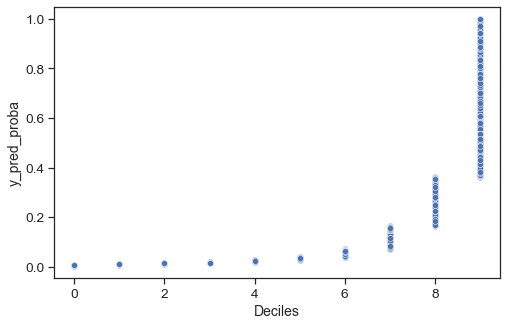

In [51]:
plt.figure(figsize=(8, 5))
sns.scatterplot(train_data.Deciles, train_data.y_pred_proba);

### Decile Analysis for test data

In [52]:
test_deciles = test_data.groupby('Deciles')[['y_pred_proba', 'y_actual']].agg({
    'y_pred_proba': ['min', 'max'],
    'y_actual': ['sum', 'count']
}).reset_index().sort_values(by='Deciles', ascending=False)
test_deciles

Deciles y_pred_proba     y_actual      
                   min max      sum count
9       9            0   1      755  1236
8       8            0   0      387  1236
7       7            0   0      177  1235
6       6            0   0       43  1235
5       5            0   0       11  1235
4       4            0   0       11  1237
3       3            0   0        6  1235
2       2            0   0        2  1236
1       1            0   0        0  1234
0       0            0   0        0  1238

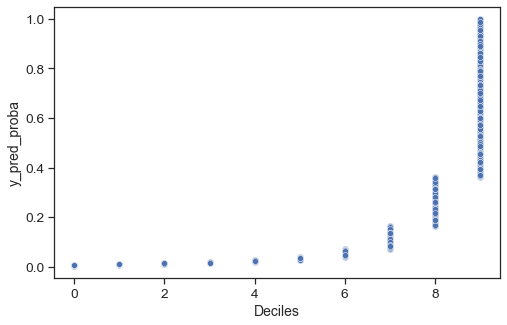

In [53]:
plt.figure(figsize=(8, 5))
sns.scatterplot(test_data.Deciles, test_data.y_pred_proba);

### Histogram of predicted probabilities

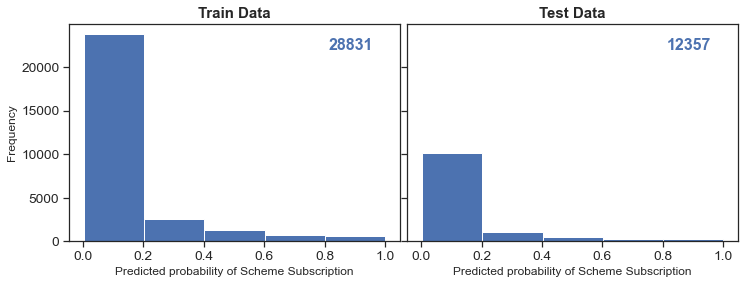

In [67]:
params = {'figure.figsize': (12, 4), 'axes.labelsize': 12}
plt.rcParams.update(params)
fig, axs = plt.subplots(1, 2, sharey=True)
plt.subplots_adjust(wspace=0.02, hspace=0)
# Train
axs[0].hist(train_data.y_pred_proba, bins=5)
axs[0].set_title('Train Data', fontdict={'fontsize': 15, 'fontweight': 'bold'})
axs[0].set_ylabel('Frequency')
axs[0].set_xlabel('Predicted probability of Scheme Subscription')
axs[0].text(0.85,
            0.9,
            str(train.shape[0]),
            horizontalalignment='center',
            verticalalignment='center',
            transform=axs[0].transAxes,
            fontsize=16,
            fontweight='bold',
            color='b')
# Test
axs[1].hist(test_data.y_pred_proba, bins=5)
axs[1].set_title('Test Data', fontdict={'fontsize': 15, 'fontweight': 'bold'})
axs[1].set_xlabel('Predicted probability of Scheme Subscription')
axs[1].text(0.85,
            0.9,
            str(test.shape[0]),
            horizontalalignment='center',
            verticalalignment='center',
            transform=axs[1].transAxes,
            fontsize=16,
            fontweight='bold',
            color='b')
plt.show()

### Checking the Ratios of Output variables in Total, Train, Test

In [55]:
pd.options.display.float_format = '{:.4f}'.format
pd.DataFrame([
    bankcalls.output.value_counts() / bankcalls.output.notna().sum(),
    train_data.y_actual.value_counts() / train_data.y_actual.notna().sum(),
    test_data.y_actual.value_counts() / test_data.y_actual.notna().sum()
],
             index=['Total Dataset', 'Train', 'Test'])

,0,1
Total Dataset,0.8873,0.1127
Train,0.8873,0.1127
Test,0.8874,0.1126


Although the output variable is split in a stratified manner in both Train and Test, the real Problem with the dataset is that the dataset is unbalanced with 89% data with Output 0 and 11% with Output 1. Hence, the model is better trained to predict which customers will not consider taking the Scheme.

## Significant Features

### By ROC_AUC_SCORE

In [56]:
df[df.Feature.isin(features)].sort_values(by='ROC_AUC_SCORE', ascending = False)

,Feature,ROC_AUC_SCORE,SomarsD
0,duration,0.8184,0.6369
0,nr_employed,0.7490,0.4980
0,month,0.6581,0.3162
0,cons_price_idx,0.6106,0.2211
0,job,0.6103,0.2205
0,previous_savings,0.6093,0.2186


### Calculating Odds Ratios

In [57]:
odds_ratios = pd.DataFrame({
    "Odds Ratio": m2.params,
    "Lower CI": m2.conf_int()[0],
    "Upper CI": m2.conf_int()[1],
})
odds_ratios = np.exp(odds_ratios)
pd.reset_option('^display.', silent=True)
print(odds_ratios)

                        Odds Ratio      Lower CI      Upper CI
Intercept             5.545638e+44  2.210073e+41  1.391543e+48
job[T.blue-collar]    7.068960e-01  6.093308e-01  8.200833e-01
job[T.entrepreneur]   8.900223e-01  6.731916e-01  1.176693e+00
job[T.housemaid]      8.792096e-01  6.400050e-01  1.207818e+00
job[T.management]     9.810004e-01  8.121945e-01  1.184891e+00
job[T.retired]        1.218048e+00  1.009276e+00  1.470004e+00
job[T.self-employed]  8.797556e-01  6.715510e-01  1.152511e+00
job[T.services]       7.668815e-01  6.348955e-01  9.263056e-01
job[T.student]        1.263733e+00  1.003558e+00  1.591360e+00
job[T.technician]     1.000254e+00  8.661045e-01  1.155182e+00
job[T.unemployed]     1.030944e+00  7.818319e-01  1.359431e+00
job[T.unknown]        1.289202e+00  7.781545e-01  2.135877e+00
month[T.aug]          1.567904e+00  1.301841e+00  1.888344e+00
month[T.dec]          1.276249e+00  8.398679e-01  1.939366e+00
month[T.jul]          1.702161e+00  1.401478e+00  2.067

### By p-values for z-scores

In [58]:
pd.options.display.float_format = '{:.5f}'.format
results_as_html = m2.summary().tables[1].as_html()
ms = (pd.read_html(results_as_html, header=0, index_col=0)[0]).sort_values(by='P>|z|')
ms_significant = ms[ms['P>|z|']<0.05]
print(ms_significant.shape[0])
ms_significant

15


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,103.02680,3.99400,25.79700,0.00000,95.19900,110.85400
nr_employed,-0.01450,0.00000,-36.80800,0.00000,-0.01500,-0.01400
cons_price_idx,-0.34480,0.04100,-8.31600,0.00000,-0.42600,-0.26400
month[T.may],-0.81160,0.08400,-9.63800,0.00000,-0.97700,-0.64700
month[T.mar],1.27150,0.13500,9.43000,0.00000,1.00700,1.53600
month[T.jun],0.65820,0.09900,6.67300,0.00000,0.46500,0.85200
month[T.jul],0.53190,0.09900,5.36300,0.00000,0.33800,0.72600
duration,0.00460,0.00009,53.21100,0.00000,0.00400,0.00500
month[T.aug],0.44970,0.09500,4.74000,0.00000,0.26400,0.63600
job[T.blue-collar],-0.34690,0.07600,-4.57700,0.00000,-0.49500,-0.19800


In [59]:
# Intercept Value
ms_significant.T.Intercept[0]

103.0268

### Final Comments

So, while campaigning for new Savings Scheme the bank should focus on : 
1. **nr_employed** : number of employees. quarterly indicator (numeric)
2. **cons_price_idx** : consumer price index. monthly indicator (numeric)
3. **month** : last contact month of year (only : **'mar', 'may', 'jun', 'jul', 'aug', 'sept'**)
4. **duration** : last contact duration, in seconds (numeric)
5. **job** : type of job (only : **'blue-collar', 'retired', 'services', 'student'**)
6. **previous_savings** : number of contacts performed before this campaign and for this client (numeric)